# Interactive Hikurangi Rupture Generator Demo

A jupyter notebook to visualise 'almost rectangular' rupture sets on the Hikurangi Subduction zone for 
the NSHM-NZ Grand Inversion.

Tips:  

 - on first load, the cells will contain the static output of the last run.
 - to go **interactive## - select menu option **Kernel/Restart & Run all**
 - When all the cells have run you should see an interactive plot with controls to manipulate the content. 
 - drag the image to change the viewpoint (warning - it's slow!)
 - you can explore different rupture set parameters by tweaking the spec code in [Rupture-specifications](#Rupture-specifications)
   

In [1]:
!pip install geopandas >/dev/null
!pip install ipympl >/dev/null

In [2]:
%matplotlib notebook
import geopandas as gpd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib import cm
from io import BytesIO
import codecs
import requests

In [3]:
module_uri = "https://github.com/GNS-Science/nshm-nz-opensha/raw/python_ruptures_101/python/src/fault_section.py"
url = requests.get(module_uri, allow_redirects=True)
bytesio_object = BytesIO(url.content)
# Write the stuff
with open("fault_section.py", "wb") as f:
    f.write(bytesio_object.getbuffer())

import fault_section
from fault_section import FaultSubSectionFactory, SheetFault

In [4]:
url = "https://github.com/GNS-Science/nshm-nz-opensha/blob/python_ruptures_101/data/subduction/tile_outlines.zip?raw=true"
tile_outlines = gpd.read_file(url)
# # Convert to NZTM
tile_outlines_nztm = tile_outlines.to_crs(epsg=2193)

In [5]:
# Extract coordinates and place in list that can be read by matplotlib
all_tile_ls = [list(tile.boundary.coords) for tile in tile_outlines_nztm.geometry]

# Coordinates of tile corners
all_coordinates = np.array([tile[:-1] for tile in all_tile_ls])
# Coordinates of tile centres
tile_centres = np.mean(all_coordinates, axis=1)
# Z values of centres (for colormap)
tile_centre_z = tile_centres[:, -1]

In [6]:
url = "https://github.com/GNS-Science/nshm-nz-opensha/blob/python_ruptures_101/data/subduction/tile_parameters.csv?raw=true"
tile_params = BytesIO(requests.get(url).content)
StreamReader = codecs.getreader('utf-8')
wrapper_file = StreamReader(tile_params)

factory = FaultSubSectionFactory()
sheet_fault = SheetFault("Hikurangi")\
		.build_surface_from_csv(factory, wrapper_file)

## Rupture specifications

Use the examples below to produce different rupture sets.

  1. tweak the parameters in this block, 
  1. from the menu, choose **Cell/Run All Below** to update the visualisation.

In [7]:
# Variations on 'nearly rectangular' rupture sets ..
#
# scale: determines ratio of rectangle to tile size (10km*10km).
# aspect: ratio of 'along-strike' tiles to 'down-dip' tiles per rectangle.
# interval: how many tiles to advance (both col-wise and row-wise)
# min_fill_factor: how many tiles are needed for a valid 'rectangle' where 1.0 = no missing tiles.

def ruptures_for(spec):
    return [rupt for rupt in sheet_fault.get_rupture_ids(spec)]

ruptures = {'spec0 3*6_@1':      ruptures_for(dict(scale=3, aspect=2)),
            'spec1 4*16 @4':       ruptures_for(dict(scale=4, aspect=4, interval=4)), #default min_fill_factor is 0.75  
            'spec2 8*16  @4 0.55': ruptures_for(dict(scale=8, aspect=2, interval=4, min_fill_factor=0.55)), 
            'spec3 16*16 @4 0.33': ruptures_for(dict(scale=16, aspect=1, interval=4, min_fill_factor=0.33)), 
            'spec4 16*32 @4 0.33': ruptures_for(dict(scale=16, aspect=2, interval=4, min_fill_factor=0.33)), 
            'spec5 3*36 @2 0.55':  ruptures_for(dict(scale=3, aspect=12, interval=2, min_fill_factor=0.55))} 

<IPython.core.display.Javascript object>


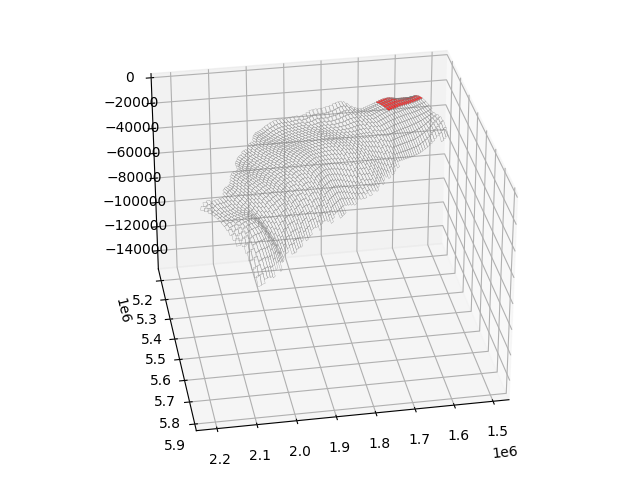

interactive(children=(Dropdown(description='spec', options=('spec0 3*6_@1', 'spec1 4*16 @4', 'spec2 8*16  @4 0…

In [8]:
from ipywidgets import interactive, IntSlider
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

line_colour = "gray"
line_width = 0.2
rupture_alpha = 0.8
rupture_colour = "red"

# Create collections for matplotlib
line_collection = Line3DCollection(all_tile_ls, linewidths=line_width, colors=line_colour)
rupture_collection = Poly3DCollection([], alpha=rupture_alpha, facecolors=rupture_colour)

def config_plot_axes(fig):
    ax = p3.Axes3D(fig)
    ax.add_collection3d(line_collection)
    ax.add_collection3d(rupture_collection)
    # Find bottom left corner of z=0 plane
    bounds = tile_outlines_nztm.bounds
    x1, y1 = min(bounds.minx), min(bounds.miny)
    x_range = max(bounds.maxx) - x1
    y_range = max(bounds.maxy) - y1

    # Width is the larger of the x and y ranges
    plot_width = max([x_range, y_range])
    # Top right corner of z=0 plane
    x2 = x1 + plot_width
    y2 = y1 + plot_width

    # Factor by which to vertically exaggerate z axis of plot
    vertical_exaggeration = 5

    # Set x, y, z limits so plot has equal aspect ratio
    ax.set_ylim((y1, y2))
    ax.set_xlim((x1, x2))
    ax.set_zlim((-(1/vertical_exaggeration) * plot_width, 10))
    ax.view_init(elev=30., azim=80)


fig = plt.figure()
config_plot_axes(fig)

def draw_rupture(spec, frame):
    rupture = ruptures[spec]
    #pos = int(frame/100 * len(rupture))
    #print(len(rupture), frame, pos)
    rupture_tiles = [sheet_fault.sub_sections[ssid].tile_coords for ssid in rupture[frame]]
    rupture_collection.set_verts(rupture_tiles)
    plt.show()

spec_opts = ruptures.keys()
frame_opts = IntSlider(value=0, min=0, max=100, description='Rupture id:')

interactive_plot = interactive(draw_rupture, spec=spec_opts, frame=frame_opts)
interactive_plot